# Final Project
### Authors: Manoj Tirukovela (mtirukov), Anirudh Ashok Patil (apatil3)

# 1. Import Dependencies

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [4]:
ds = tfds.load('mnist', split='train')

# 2. Load Dataset

In [6]:
dataiterator = ds.as_numpy_iterator()

In [7]:
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
      

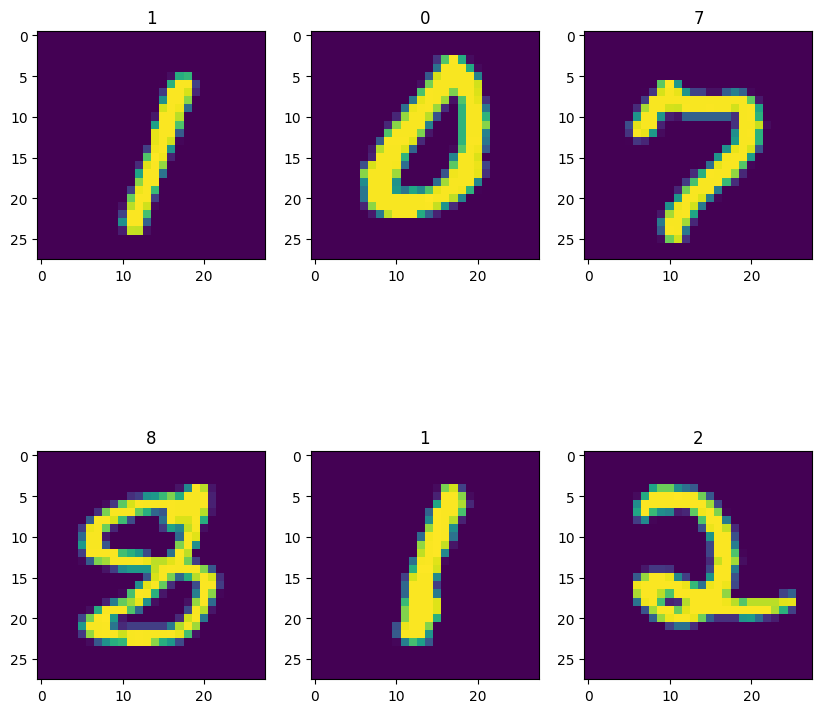

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
for x in range(2):
  for y in range(3):
    sample = dataiterator.next()
    ax[x][y].imshow(np.squeeze(sample['image']))
    ax[x][y].title.set_text(sample['label'])

In [10]:
def scale_images(data):
    image = data['image']
    label = data['label']
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [11]:
ds = tfds.load('mnist', split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(50000)
ds = ds.batch(256)
ds = ds.prefetch(64)

In [12]:
ds.as_numpy_iterator().next().shape

(256, 28, 28, 1)

# 3. Build Neural Network

In [14]:
def generator_model():
    model = Sequential()
    model.add(Dense(256, input_dim=128))
    model.add(LeakyReLU(0.2))

    model.add(Dense(512))
    model.add(LeakyReLU(0.2))

    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))

    model.add(Dense(784, activation='tanh'))
    model.add(Reshape((28,28,1)))

    return model

In [15]:
generator = generator_model()

In [16]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               33024     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

In [17]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 22ms/step


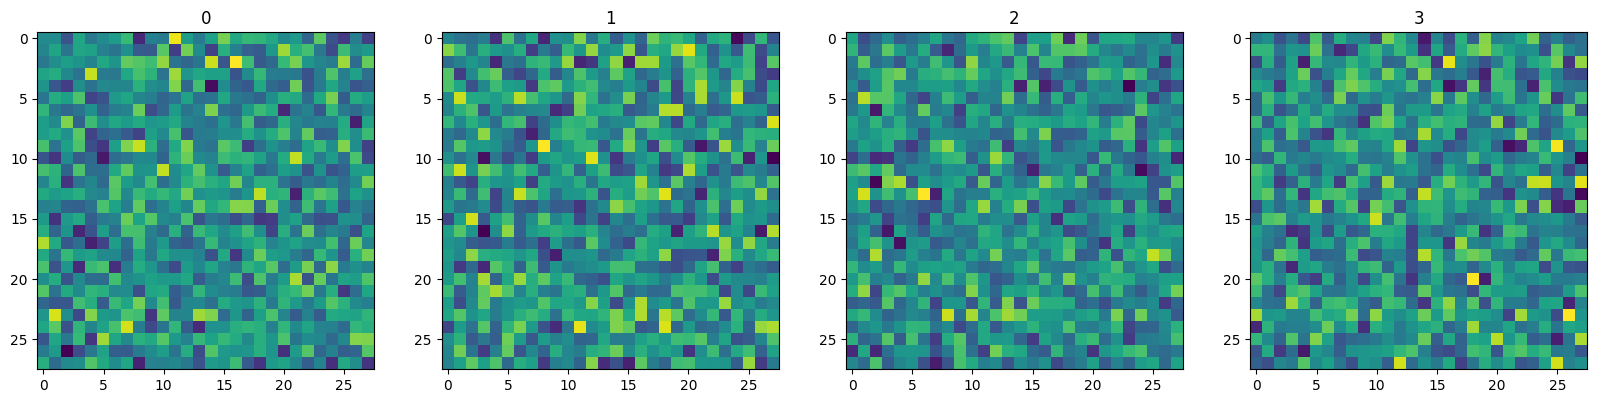

In [18]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

In [19]:
def discriminator_model():
    model = Sequential()
    model.add(Flatten(input_shape=(28,28,1)))
    model.add(Dropout(0.4))

    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [20]:
discriminator = discriminator_model()

In [21]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)              

In [22]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 24ms/step


In [23]:
discriminator.predict(img)

1/1 [==============================] - 0s 160ms/step


array([[0.5374385 ],
       [0.5214657 ],
       [0.54476273],
       [0.53559154]], dtype=float32)

# 4. Training

In [25]:
g_opt = Adam(learning_rate=0.0002, beta_1=0.5)
d_opt = Adam(learning_rate=0.0002, beta_1=0.5)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [26]:
from tensorflow.keras.models import Model

In [27]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [28]:
gan = GAN(generator, discriminator)

In [29]:
gan.compile(g_opt, d_opt, g_loss, d_loss)

#### Note: Make sure to create a folder called 'images' in the current directory. This folder will be used to save the generated images every 50 epochs during training.

In [31]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
      if(epoch + 1) % 50 == 0:
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [32]:
hist = gan.fit(ds, epochs=350, callbacks=[ModelMonitor()])

Epoch 1/350
235/235 [==============================] - 8s 6ms/step - d_loss: 0.5531 - g_loss: 0.9414
Epoch 2/350
235/235 [==============================] - 1s 6ms/step - d_loss: 0.4612 - g_loss: 1.4190
Epoch 3/350
235/235 [==============================] - 1s 6ms/step - d_loss: 0.4980 - g_loss: 1.6353
Epoch 4/350
235/235 [==============================] - 1s 6ms/step - d_loss: 0.5070 - g_loss: 1.8299
Epoch 5/350
235/235 [==============================] - 1s 6ms/step - d_loss: 0.4687 - g_loss: 2.0909
Epoch 6/350
235/235 [==============================] - 1s 5ms/step - d_loss: 0.4909 - g_loss: 1.7144
Epoch 7/350
235/235 [==============================] - 1s 5ms/step - d_loss: 0.5090 - g_loss: 1.4665
Epoch 8/350
235/235 [==============================] - 1s 6ms/step - d_loss: 0.5318 - g_loss: 1.2594
Epoch 9/350
235/235 [==============================] - 1s 6ms/step - d_loss: 0.5488 - g_loss: 1.1172
Epoch 10/350
235/235 [==============================] - 1s 6ms/step - d_loss: 0.5644 - g_lo

### Review Performance

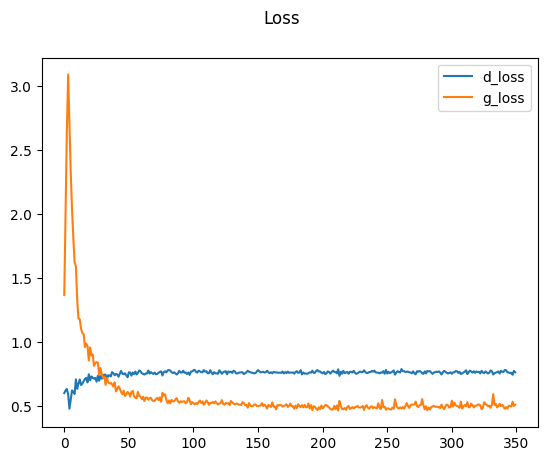

In [33]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Testing Generator

#### You can run the below cell to bring in the pre-trained weights for the generator and try out the GAN.

In [ ]:
generator.load_weights('generator.h5')

In [35]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 21ms/step


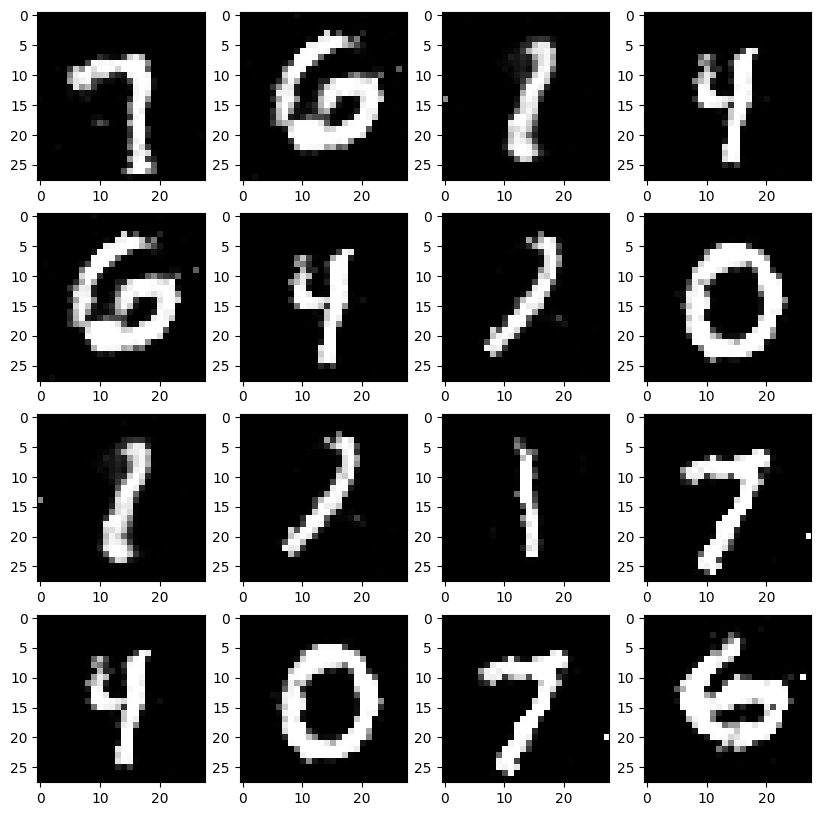

In [36]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1], cmap='gray')

### Save the Model

In [37]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
